![titre](images/header.png)

# IV A - SBAE - Classification supervisée
### Utiliser des données de référence pour entrainer une classification
-------

Ce bloc-notes vous guide tout au long du processus de création d'un sous-échantillon de la série chronologique et des données de modification récupérées dans III et interprétées visuellement. 
L'objectif est d'obtenir une variable continue qui décrive la population (par ex. probabilité de changement)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt

/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### 1 Charger et préparer les données CEO

In [2]:
# read csv file
ceo = pd.read_csv('/home/sepal-user/sbae_point_analysis_CIV/erp_1km/ign_ERP_CIV_692pts_20221026.csv', delimiter=',')
print(ceo.columns)
ceo.head(1)

Index(['X', 'Y', 'PLOTID', 'LON', 'LAT', 'strate', 'prob_chang', 'ID',
       'INT1_2000', 'INT1_2010', 'INT1_2015', 'INT1_2020', 'INT1_2021',
       'CHG_20_21', 'CHG_00_10', 'CHG_10_15', 'CHG_15_20', 'IC', 'COMMENT.',
       'P-I_name'],
      dtype='object')


,X,Y,PLOTID,LON,LAT,strate,prob_chang,ID,INT1_2000,INT1_2010,INT1_2015,INT1_2020,INT1_2021,CHG_20_21,CHG_00_10,CHG_10_15,CHG_15_20,IC,COMMENT.,P-I_name
0,49534.66052,568818.388616,63667,-7.061038,5.133202,3,0.523027,346,21,21,21,21,21,Stable,Stable,Stable,Stable,1,NaN,AMO


In [4]:
# subset columns
ceo = ceo[['PLOTID', 'LON', 'LAT', 'CHG_00_10', 'CHG_10_15']]

# add CNC column for classification
ceo['cnc_0010'] = ceo['CHG_00_10'].apply(lambda x: 1 if x == 'Deforestation' else 0)
ceo['cnc_1015'] = ceo['CHG_10_15'].apply(lambda x: 1 if x == 'Deforestation' else 0)
ceo['cnc']      = ceo['cnc_0010'] + ceo['cnc_1015']

ceo.head(5)
np.unique(ceo['cnc'], return_counts=True)

(array([0, 1]), array([580, 112]))

### 2 Charger et préparer les données TS

In [5]:
# load data
ts = pd.read_pickle('/home/sepal-user/sbae_point_analysis_CIV/erp_1km/erp_bdd_ts_aux_1km.pickle')

In [6]:
ts[['dates', 'ts', 'images']].head(5)
len(ts)

46415

In [7]:
# turn nan to 0
ts['gfc_lossyear'] = np.nan_to_num(ts['gfc_lossyear'])
# create a binary loss
ts['gfc_loss_binary'] = ts['gfc_lossyear'].apply(lambda x: 0 if x == 0 or x > 15 else 1)

In [8]:
# create a binary deforestation
ts['tmf_def_binary'] = ts['tmf_defyear'].apply(lambda x: 1 if x > 1999 and x <= 2015 else 0)

# create a binary degradation
ts['tmf_deg_binary'] = ts['tmf_degyear'].apply(lambda x: 1 if x > 1999 and x <= 2015 else 0)

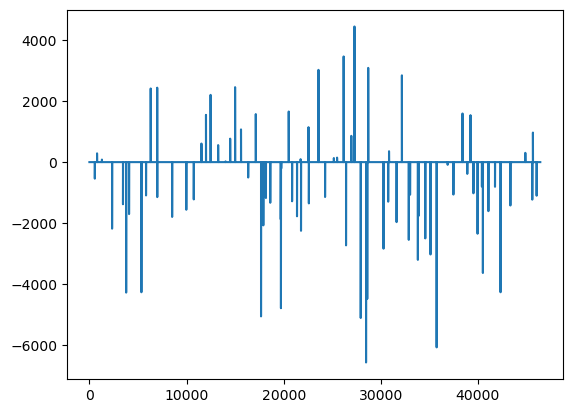

In [9]:
ts['ltr_magnitude'].plot()

### 2.1 Sélectionner les colonnes pour la classification

In [10]:
cols_to_classify = [
    'images', 'mon_images',
    'gfc_tc00', 
    'gfc_loss_binary',
    'tmf_2000', 
    'tmf_def_binary', 'tmf_deg_binary',
    'bfast_magnitude',
    'ccdc_magnitude', 
    'ltr_magnitude', 'ltr_dur', 'ltr_rate',
    'cusum_confidence', 'cusum_magnitude', 
    'ts_mean', 'ts_sd', # we add this anyway in the next cell
    'ts_min', 'ts_max',
    'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min'
]


### 2.2 Extraire des statistiques de séries chronologiques pour chaque bande et les ajouter aux colonnes de données prédictives

In [11]:
bands = list(ts['ts'][1].keys())
print(' Bands available in dataset time-series: ')
print(bands) 
for band in bands:
    
    # add mean and SD value of time-series for each band
    ts[band + '_mean'] = ts['ts'].apply(lambda x: np.nanmean(np.array(x[band])))
    ts[band + '_sd'] = ts['ts'].apply(lambda x: np.nanstd(np.array(x[band])))
    
    # append to classification bands
    cols_to_classify.append(band + '_mean')
    cols_to_classify.append(band + '_sd')

 Bands available in dataset time-series: 
['green', 'red', 'nir', 'swir1', 'swir2', 'ndfi']


In [12]:
cols_to_classify

['images',
 'mon_images',
 'gfc_tc00',
 'gfc_loss_binary',
 'tmf_2000',
 'tmf_def_binary',
 'tmf_deg_binary',
 'bfast_magnitude',
 'ccdc_magnitude',
 'ltr_magnitude',
 'ltr_dur',
 'ltr_rate',
 'cusum_confidence',
 'cusum_magnitude',
 'ts_mean',
 'ts_sd',
 'ts_min',
 'ts_max',
 'bs_slope_mean',
 'bs_slope_sd',
 'bs_slope_max',
 'bs_slope_min',
 'green_mean',
 'green_sd',
 'red_mean',
 'red_sd',
 'nir_mean',
 'nir_sd',
 'swir1_mean',
 'swir1_sd',
 'swir2_mean',
 'swir2_sd',
 'ndfi_mean',
 'ndfi_sd']

In [13]:
print(' Number of predictive features: ' + str(len(cols_to_classify)))

 Number of predictive features: 34


### 2.3 Ajouter une colonne Kmeans (parce que nous le pouvons)

In [14]:
nr_of_cluster=50

# run kmeans
kmeans_model = KMeans(n_clusters=nr_of_cluster, random_state=42).fit(ts[cols_to_classify])
ts['kmeans'] = kmeans_model.predict(ts[cols_to_classify])

cols_to_classify.append('kmeans')

### 3 Fusionner les données CEO et de TS

In [15]:
df_class = pd.merge(ceo, ts[cols_to_classify + ['PLOTID']], how='inner', left_on='PLOTID', right_on='PLOTID')

### 4 Classification - Création d'un modèle d'ensemble

### 4.1 Partage entre Train-Test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_class[cols_to_classify + ['PLOTID']], df_class['cnc'], test_size=0.2, random_state=42, stratify=df_class['cnc'])

In [17]:
X_train
len(X_train)

553

In [19]:
X_test
print(len(X_test))
X_test.head()

139


,images,mon_images,gfc_tc00,gfc_loss_binary,tmf_2000,tmf_def_binary,tmf_deg_binary,bfast_magnitude,ccdc_magnitude,ltr_magnitude,...,nir_mean,nir_sd,swir1_mean,swir1_sd,swir2_mean,swir2_sd,ndfi_mean,ndfi_sd,kmeans,PLOTID
563,78,74,40,0,6,0,0,4275.056641,0.0,0.0,...,3212.800866,577.427955,1913.096537,352.719821,904.142641,335.063332,8165.217100,1232.001954,28,46551
642,118,111,44,0,6,0,0,-1831.683105,0.0,0.0,...,3024.881766,577.592753,1873.336467,274.269474,906.967236,217.930530,7589.755556,1608.013610,45,58206
1,63,59,37,0,1,1,0,-3389.856445,0.0,0.0,...,2963.932796,457.644274,1956.579301,372.719278,947.737903,262.989686,7161.393817,1728.199561,45,63833
75,56,53,47,0,1,0,1,0.000000,0.0,0.0,...,3444.401212,610.703876,2104.350303,424.810019,1030.142121,284.854562,7833.838485,1356.656872,3,81863
382,53,51,71,1,1,0,0,0.000000,0.0,0.0,...,3386.218498,705.919237,1852.021383,474.382877,841.656822,254.406177,8921.879991,890.611249,40,129333


### 4.2 Classification RF avec optimisation automatisée du modèle pour éviter les faux positifs dans la classe stable

In [20]:
clf = RandomForestClassifier(n_jobs=-1, oob_score=True)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [125, 250, 500],
    #'max_depth': [3, 5, 15, 25],
    'max_features': [5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}


def grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    
    skf = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score, cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train[cols_to_classify], y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test[cols_to_classify])

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_features': 20, 'min_samples_split': 5, 'n_estimators': 125}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg       110         7
pos        10        12


### 4.3 Précision du modèle

-----------------------------
 Stats on train:
-----------------------------
Accuracy on train: 0.9963833634719711


array([[463,   0],
       [  2,  88]])



-----------------------------
 Stats on test:
-----------------------------
Accuracy on test: 0.8776978417266187


array([[110,   7],
       [ 10,  12]])



-----------------------------
 Per class stats on test:
-----------------------------
              precision    recall  f1-score   support

      stable     0.9167    0.9402    0.9283       117
      change     0.6316    0.5455    0.5854        22

    accuracy                         0.8777       139
   macro avg     0.7741    0.7428    0.7568       139
weighted avg     0.8715    0.8777    0.8740       139



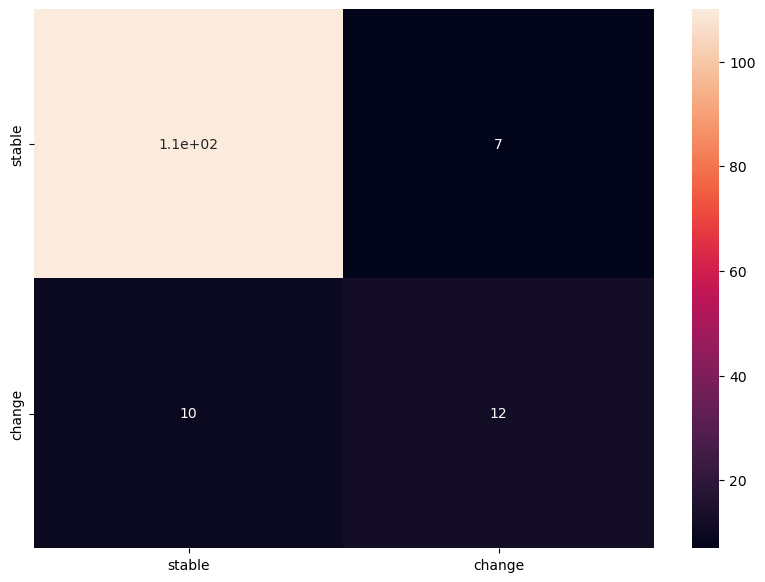

In [21]:
X_train['class'] = grid_search_clf.predict(X_train[cols_to_classify])
X_test['class'] = grid_search_clf.predict(X_test[cols_to_classify])

print('-----------------------------')
print(' Stats on train:')
print('-----------------------------')
print('Accuracy on train: ' + str(accuracy_score(y_train, X_train['class'])))
display(confusion_matrix(y_train, X_train['class']))

print('')
print('')
print('-----------------------------')
print(' Stats on test:')
print('-----------------------------')
#print('Out of Bag Error RF: ' + str(grid_search_clf.oob_score_))
print('Accuracy on test: ' + str(accuracy_score(y_test, X_test['class'], )))
cm = confusion_matrix(y_test, X_test['class'])
display(cm)

print('')
print('')
print('-----------------------------')
print(' Per class stats on test:')
print('-----------------------------')
print(classification_report(y_test, X_test['class'], target_names=['stable', 'change'], digits=4))

df_cm = pd.DataFrame(cm, index=['stable', 'change'], columns=['stable', 'change'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

### 4.4 Importance des composantes

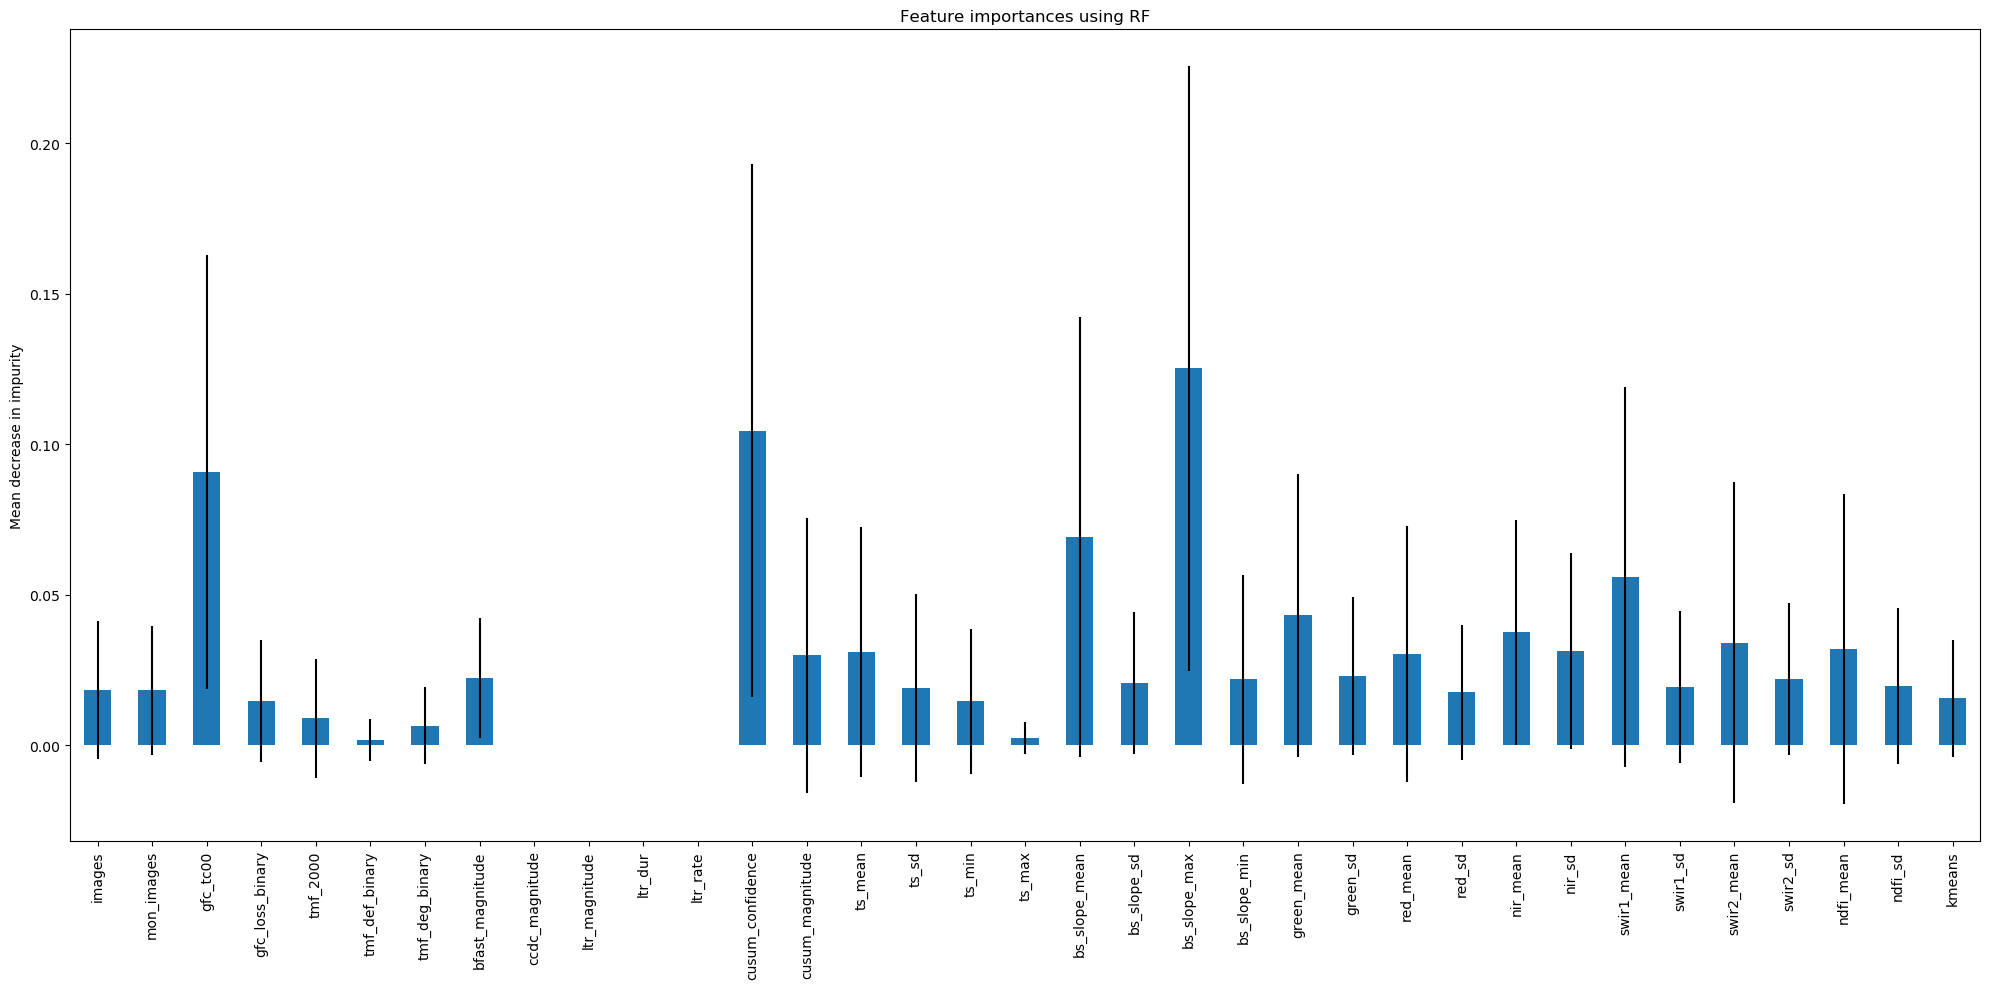

In [22]:
forest = grid_search_clf.best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
feature_names = [f"{i}" for i in X_train[cols_to_classify].columns]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using RF")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 4.4 Détermination du seuil pour ne pas avoir de changement

In [ ]:
df_class[['prob_stable', 'prob_change']] = grid_search_clf.predict_proba(df_class[cols_to_classify][cols_to_classify])

print('Maximum probability of stable for change points')
#thshld = df_class['prob_stable'][df_class['cnc'] == 1].max()
thshld = np.percentile(df_class['prob_stable'][df_class['cnc'] == 1], 100)
print(thshld)

print('Reasonable probability of stable for change points')
#thshld = df_class['prob_stable'][df_class['cnc'] == 1].max()
thshld = np.percentile(df_class['prob_stable'][df_class['cnc'] == 1], 90)
print(thshld)

print('Number of points above thshld (considered stable)')
abv_thshld = df_class[df_class['prob_stable'] > thshld]
print(str(len(abv_thshld)) + ' out of ' + str(len(df_class)))

print('Number of actual change points left in stable')
print(len(abv_thshld[abv_thshld['cnc'] == 1]))

print(' Point Ids of interpreted change with a high probability of being stable')
display(df_class[(df_class['cnc'] == 1) & (df_class['prob_stable'] > thshld)].sort_values('prob_stable', ascending=False))

In [ ]:
print(X_test.columns)
len(X_test)

In [ ]:
X_test[['prob_stable', 'prob_change']] = grid_search_clf.predict_proba(X_test[cols_to_classify])
X_test['cnc'] = y_test
X_test.to_csv('/home/sepal-user/sbae_point_analysis_CIV/erp_1km/validation_ign_ERP_CIV_IC_113pts.csv', index=False)

In [ ]:
df_class['prob_stable'].hist()
len(df_class)

X_test['prob_stable'].hist()


In [ ]:
fp_ids = df_class[(df_class['cnc'] == 1) & (df_class['prob_stable'] > thshld)]['PLOTID']

In [ ]:
len(df_class)

### 5 Appliquer le modèle d'ensemble à TOUS les points

In [ ]:
ts['cnc_class'] = grid_search_clf.predict(ts[cols_to_classify])
ts[['prob_stable', 'prob_change']] = grid_search_clf.predict_proba(ts[cols_to_classify])

print(' Number of points to visually recheck based on classification result (0.5 probability)')
print(len(ts[ts['cnc_class'] == 1]))


print(' Number of points to visually recheck based on adjusted probability')
print(len(ts[ts['prob_stable'] < thshld]))

In [ ]:
ts['prob_stable'].hist(bins=60)

In [ ]:
print(ts.columns)

#### Exporter les résultats

In [ ]:
out_csv_file = '/home/sepal-user/sbae_point_analysis_CIV/erp_1km/bdd_erp_2000_2015_supervised_IC_ign.csv'
#tout = ts[['PLOTID','LON', 'LAT','kmeans','cnc_class', 'prob_stable', 'prob_change']]
tout = ts
tout.to_csv(out_csv_file, index=False)

### 6 Sélectionnez les points de changement les plus probables en fonction de la probabilité

In [ ]:
# Number of points you can afford to analyse
nr_of_points = 3300

# select
selection = ts[['PLOTID', 'prob_change']].sort_values('prob_change', ascending=False).head(nr_of_points)
display(selection)
print('Minimum change probability included in selection: ' + str(selection['prob_change'].min()))

### 7 Sélectionnez la plupart des points de zone grise selon le modèle

In [ ]:
print(' Number of points to visually recheck based on margin of classifier') 
ts[['PLOTID', 'prob_change']][(ts['prob_change'] > 0.5) & (ts['prob_change'] < 0.55)].sort_values('prob_change', ascending=False)